# Building a simple PSHA model using rshalib

This is a template for building a generic simple PSHA model (without logic tree)
that can be run in OpenQuake, oq-hazardlib or CRISIS.

## 0. Import modules

In [1]:
## Standard modules
import os
import datetime
from collections import OrderedDict
import numpy as np
import pylab

## Thirdparty (hazardlib)
from openquake.hazardlib.imt import PGA, SA

## ROB modules
import eqcatalog
import hazard.rshalib as rshalib

## Increase default plot size
pylab.rcParams['figure.figsize'] = (8,8)

OpenQuake version: 0.11.0


## 1. Model parameters

### 1.1 Model name and folder names

In [2]:
### Model name
psha_model_name = "SHRE_NPP_example"

### Folder names
psha_root_folder = r"D:\PSHA\SHRE_NPP\rshalib_demo"
psha_model_folder = os.path.join(psha_root_folder, psha_model_name)
if not os.path.exists(psha_model_folder):
    os.mkdir(psha_model_folder)

### 1.2 PSHA parameters

In [3]:
## Threshold magnitude and MFD bin width
Mmin_mfd = 2.2
Mmin = 4.5
mfd_bin_width = 0.1

## GMPE truncation level (in number of standard deviations)
gmpe_truncation_level = 3

## Discretization parameters (in km)
rupture_mesh_spacing = 2.5
area_discretization = 10.
integration_distance = 100.

## Return periods and investigation time
return_periods = [1E+3, 1E+4, 1E+5]
investigation_time = 50.

### 1.3 Site specification

In [4]:
## Grid
grid_outline = [(2.15, 49.15), (6.95, 51.95)]
#grid_spacing = 0.1
#grid_spacing = 1.0
grid_spacing = '10km'
#site_model = rshalib.site.GenericSiteModel.from_grid_spec(grid_outline, grid_spacing)

## List of sites
#sites = []
sites = [rshalib.site.GenericSite(4.259, 51.325, name='Doel')]
site_model = rshalib.site.GenericSiteModel(sites)

## Site model including soil parameters
vs30, vs30measured, z1pt0, z2pt5 = 800., True, 2., 1.
ref_site_params = (vs30, vs30measured, z1pt0, z2pt5)
#site_model = rshalib.Site.SoilSiteModel([(3.71704, 51.43233)])

### 1.4 Intensity measure type, spectral periods, and intensity levels

In [5]:
## Intensity measure type, spectral periods, and intensity levels
#imt_periods = {'PGA': [0], 'SA': [0.5, 1.]}
imt_periods = {'PGA': [0]}
Imin = 1E-3
Imax = 1.0
num_intensities = 25

## 2. Read and process seismic catalog

### 2.1 Catalog parameters

In [6]:
Mtype = "MW"
Mrelation = OrderedDict([("MS", "Geller1976"), ("ML", "Ahorner1983")])
completeness = eqcatalog.rob.Completeness_MW_201303a
region = (-1.25, 8.75, 49.15, 53.30)
start_date = datetime.date(1350, 1, 1)
end_date = datetime.date(2019, 12, 31)
Mmax = 7.1

### 2.2 Read raw catalog from database

In [7]:
raw_catalog = eqcatalog.rob.query_local_eq_catalog(region=region, Mmin=0.1,
                                    start_date=start_date, end_date=end_date)
raw_catalog.name = 'ROB Catalog (raw)'
raw_catalog.print_info()

+-------------------+--------------------------+
|     Parameter     |          Value           |
+-------------------+--------------------------+
|    Catalog name   |    ROB Catalog (raw)     |
| Earthquake number |           2218           |
|     Start time    | 1350-01-01T00:00:00.000  |
|      End time     | 2019-12-31T00:00:00.000  |
|  Longitude bounds |     -0.7700 / 8.7125     |
|  Latitude bounds  |    49.1630 / 53.2501     |
|    Depth range    |      0.0 / 42.6 km       |
|         MW        |  n=15, min=0.9, max=6.1  |
|         MS        |  n=49, min=0.2, max=6.3  |
|         ML        | n=2180, min=0.1, max=5.8 |
|    Event types    |       ke (n=2218)        |
+-------------------+--------------------------+


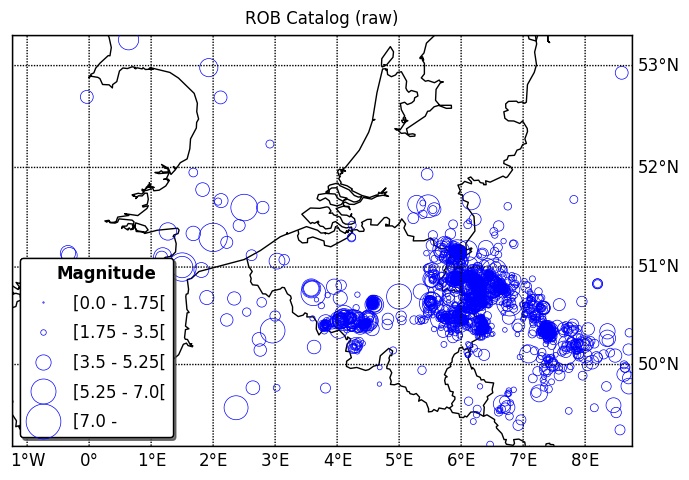

In [8]:
raw_catalog.plot_map()

### 2.3 Decluster

In [9]:
dc_method = eqcatalog.declustering.LinkedWindowMethod()
dc_window = eqcatalog.declustering.Gruenthal2009Window()
dc_catalog = raw_catalog.subselect_declustering(dc_method, dc_window,
            Mrelation=Mrelation, catalog_name='ROB Catalog (declustered)')
dc_catalog.print_info()

+-------------------+---------------------------+
|     Parameter     |           Value           |
+-------------------+---------------------------+
|    Catalog name   | ROB Catalog (declustered) |
| Earthquake number |            1190           |
|     Start time    |  1350-01-01T00:00:00.000  |
|      End time     |  2019-12-31T00:00:00.000  |
|  Longitude bounds |      -0.7700 / 8.7125     |
|  Latitude bounds  |     49.1630 / 53.2501     |
|    Depth range    |       0.0 / 42.6 km       |
|         MW        |   n=14, min=0.9, max=6.1  |
|         MS        |   n=34, min=2.0, max=6.3  |
|         ML        |  n=1165, min=0.1, max=5.8 |
|    Event types    |        ke (n=1190)        |
+-------------------+---------------------------+


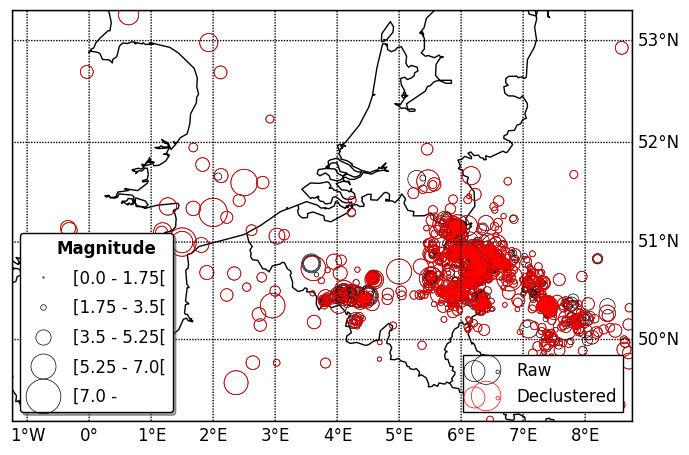

In [10]:
eqcatalog.plot.plot_map([raw_catalog, dc_catalog], Mtype=Mtype, Mrelation=Mrelation,
                        edge_colors=['k', 'r'], labels=["Raw", "Declustered"])

### 2.4 Apply completeness constraint

In [11]:
cc_catalog = dc_catalog.subselect_completeness(Mtype=Mtype, Mrelation=Mrelation,
                                                completeness=completeness)
cc_catalog.name = 'ROB Catalog (completeness-constrained)'
cc_catalog.print_info()

Number of events constrained by completeness criteria: 375 out of 1190
+-------------------+----------------------------------------+
|     Parameter     |                 Value                  |
+-------------------+----------------------------------------+
|    Catalog name   | ROB Catalog (completeness-constrained) |
| Earthquake number |                  375                   |
|     Start time    |        1350-01-01T00:00:00.000         |
|      End time     |        2019-12-31T00:00:00.000         |
|  Longitude bounds |            -0.4218 / 8.7125            |
|  Latitude bounds  |           49.3179 / 53.2501            |
|    Depth range    |             0.0 / 27.9 km              |
|         ML        |        n=360, min=1.9, max=5.8         |
|         MW        |         n=4, min=2.3, max=6.1          |
|         MS        |         n=29, min=2.0, max=6.3         |
|    Event types    |               ke (n=375)               |
+-------------------+--------------------------

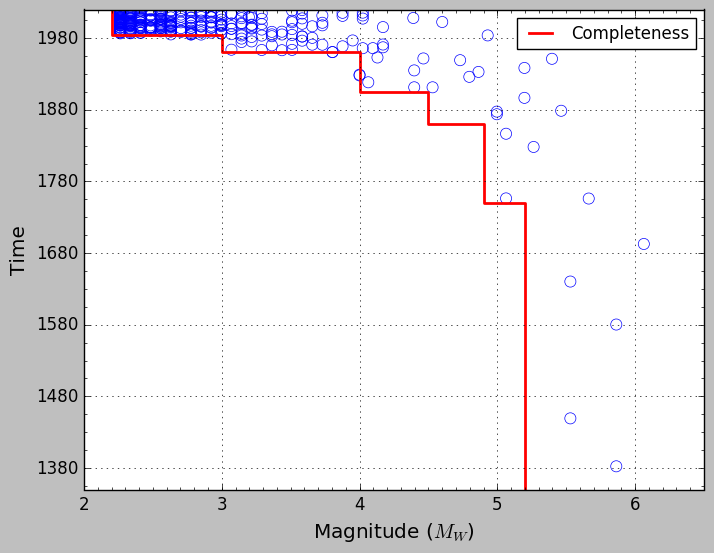

In [12]:
cc_catalog.plot_magnitude_time(Mtype=Mtype, Mrelation=Mrelation,
                                completeness=completeness)

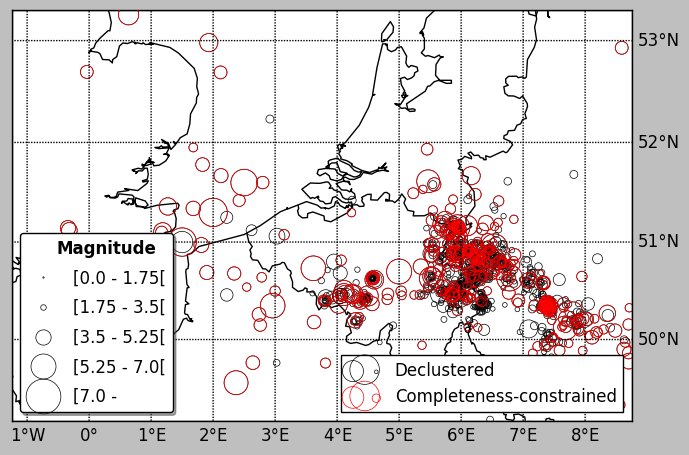

In [13]:
eqcatalog.plot.plot_map([dc_catalog, cc_catalog], Mtype=Mtype, Mrelation=Mrelation,
                        edge_colors=['k', 'r'], labels=["Declustered", "Completeness-constrained"])

## 3. Construct source model

In [14]:
source_model_name = "Seismotectonic_Hybrid"

### 3.1 Construct nodal plane distribution

In [15]:
min_strike, max_strike, delta_strike = 0, 270, 90
dip = 45.
min_rake, max_rake, delta_rake = -90, 90, 90
#min_rake, max_rake, delta_rake = 0, 0, 0
npd = rshalib.pmf.create_nodal_plane_distribution((min_strike, max_strike, delta_strike),
                                                dip, (min_rake, max_rake, delta_rake))
npd.print_distribution()

Strike Dip Rake Weight
     0  45  -90 0.0833
     0  45    0 0.0833
     0  45   90 0.0833
    90  45  -90 0.0833
    90  45    0 0.0833
    90  45   90 0.0833
   180  45  -90 0.0833
   180  45    0 0.0833
   180  45   90 0.0833
   270  45  -90 0.0833
   270  45    0 0.0833
   270  45   90 0.0837


### 3.2 Construct hyocentral depth distribution

In [16]:
hypo_depths, hypo_weights = rshalib.pmf.get_normal_distribution(5., 20., 4)
hdd = rshalib.pmf.HypocentralDepthDistribution(hypo_depths, hypo_weights)
hdd.print_distribution()

Depth Weight
 5.00 0.0723
10.00 0.4278
15.00 0.4278
20.00 0.0721


### 3.3 Read source model from GIS table

In [17]:
source_model = rshalib.rob.read_source_model(source_model_name, min_mag=Mmin,
                mfd_bin_width=mfd_bin_width, rupture_mesh_spacing=rupture_mesh_spacing,
                area_discretization=area_discretization, hypocentral_distribution=hdd,
                nodal_plane_distribution=npd)

Number of layers: 1
Fixing older MapInfo implementation of Lambert1972...
Number of features in layer 0: 28
LIE
EAM
MOB
ABM
WAZ
WAM
WNB
NB
HTM
EIF
TG
BGRVRS
ReBoFZ
ViF
ErSwF
LoKaF
RuF
MeF
KiF
SaF
StF
HeRiF
RijF
VeF
FeF
GeHeF
PeF
HOCK


### 3.4 Override tectonic region type for RVG

In [18]:
## Example of how parameters of individual sources can be overridden
source = source_model["BGRVRS"]
trt = 'Stable Shallow Crust'
source.tectonic_region_type = trt

## 4. Compute Magnitude-Frequency Distribution for each source

### 4.1 Split completeness-constrained catalog into subcatalogs corresponding to source zones

In [19]:
zone_catalogs = cc_catalog.split_into_zones(source_model_name)

Number of layers: 1
Fixing older MapInfo implementation of Lambert1972...
Number of features in layer 0: 28


Number of layers: 1
Fixing older MapInfo implementation of Lambert1972...
Number of features in layer 0: 28


C:\Anaconda\lib\site-packages\matplotlib\artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


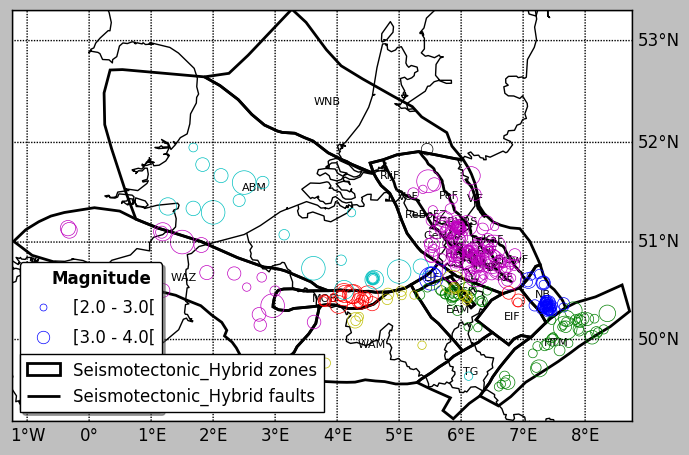

In [20]:
eqcatalog.plot.plot_map(zone_catalogs.values(), source_model=source_model_name,
                        labels=[""]*len(zone_catalogs), region=region)

### 4.2 Compute MFD for each area source

LIE
a=0.419 b=0.646
EAM
a=2.506 b=1.197
MOB
a=1.432 b=0.788
ABM
a=1.102 b=0.653
WAZ
a=1.015 b=0.668
WAM
a=2.438 b=1.339
WNB
a=0.548 b=0.962
NB
a=3.154 b=1.335
HTM
a=2.399 b=1.070
EIF
a=1.099 b=0.992
TG
BGRVRS
a=2.614 b=0.922
HOCK
a=1.351 b=0.921
Number of events constrained by completeness criteria: 23 out of 23


E:\Home\_kris\Python\seismo\eqcatalog\calcGR.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  BETA -= DLDB/D2LDB2
E:\Home\_kris\Python\seismo\eqcatalog\calcGR.py:81: RuntimeWarning: invalid value encountered in double_scalars
  DLDB = STMEX / SUMTEX
E:\Home\_kris\Python\seismo\eqcatalog\calcGR.py:85: RuntimeWarning: invalid value encountered in double_scalars
  D2LDB2 = NKOUNT * (DLDB*DLDB - STM2X/SUMTEX)
E:\Home\_kris\Python\seismo\eqcatalog\calcGR.py:98: RuntimeWarning: invalid value encountered in double_scalars
  FNGTMO = NKOUNT * SUMEXP / SUMTEX
E:\Home\_kris\Python\seismo\hazard\rshalib\mfd\plot.py:239: RuntimeWarning: divide by zero encountered in log10
  fmin = 10**np.floor(np.log10(fmin))


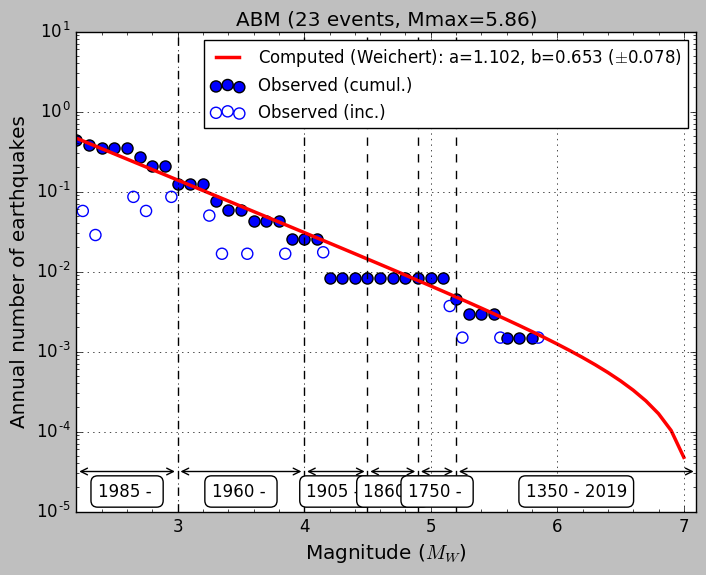

In [21]:
for zone_id, zone_catalog in zone_catalogs.items():
    zone = source_model[zone_id]
    print(zone.source_id)
    zone_catalog = zone_catalogs[zone.source_id]
    try:
        zone.mfd = zone_catalog.get_estimated_mfd(Mmin_mfd, Mmax, mfd_bin_width,
            method="Weichert", Mtype=Mtype, b_val=None, Mrelation=Mrelation,
            completeness=completeness, verbose=False)
    except:
        pass
    else:
        zone.mfd.min_mag = Mmin
        print("a=%.3f b=%.3f" % (zone.mfd.a_val, zone.mfd.b_val))
zone_catalogs["ABM"].plot_mfd(Mmin_mfd, Mmax, mfd_bin_width, method="Weichert", Mtype=Mtype,
                Mrelation=Mrelation, completeness=completeness, ymin=1E-5, ymax=10)

### 4.3 Examine parameters of a particular area source

Anglo-Brabant Massif
Upper seismogenic depth: 0.0 km
Lower seismogenic depth: 30.0 km
Area discretization: 10.0 km
Rupture mesh spacing: 2.5 km
Rupture aspect ratio: 1.0
Tectonic region type: Stable Shallow Crust
MFD a=1.102 b=0.65
Strike Dip Rake Weight
     0  45  -90 0.0833
     0  45    0 0.0833
     0  45   90 0.0833
    90  45  -90 0.0833
    90  45    0 0.0833
    90  45   90 0.0833
   180  45  -90 0.0833
   180  45    0 0.0833
   180  45   90 0.0833
   270  45  -90 0.0833
   270  45    0 0.0833
   270  45   90 0.0837
Depth Weight
 5.00 0.0723
10.00 0.4278
15.00 0.4278
20.00 0.0721


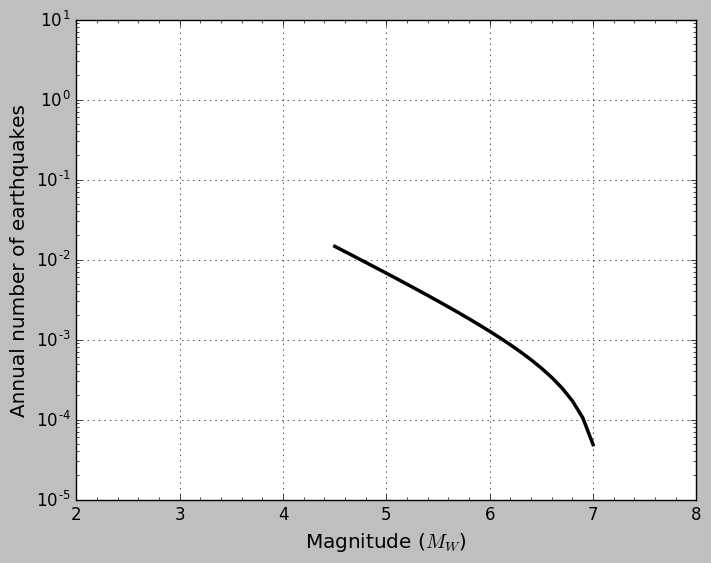

In [22]:
zone = source_model["ABM"]
print(zone.name)
print("Upper seismogenic depth: %.1f km" % zone.upper_seismogenic_depth)
print("Lower seismogenic depth: %.1f km" % zone.lower_seismogenic_depth)
print("Area discretization: %.1f km" % zone.area_discretization)
print("Rupture mesh spacing: %.1f km" % zone.rupture_mesh_spacing)
print("Rupture aspect ratio: %.1f" % zone.rupture_aspect_ratio)
print("Tectonic region type: %s" % zone.tectonic_region_type)
print("MFD a=%.3f b=%.2f" % (zone.mfd.a_val, zone.mfd.b_val))
zone.nodal_plane_distribution.print_distribution()
zone.hypocenter_distribution.print_distribution()
zone.mfd.plot(xmin=2, xmax=8, ymin=1E-5, ymax=10)

### 4.4 Inspect source ruptures

Area source: all possible ruptures of a given magnitude and rake

96
<AreaSource #LIE>
<class 'hazard.rshalib.source.area.AreaSource'>
True


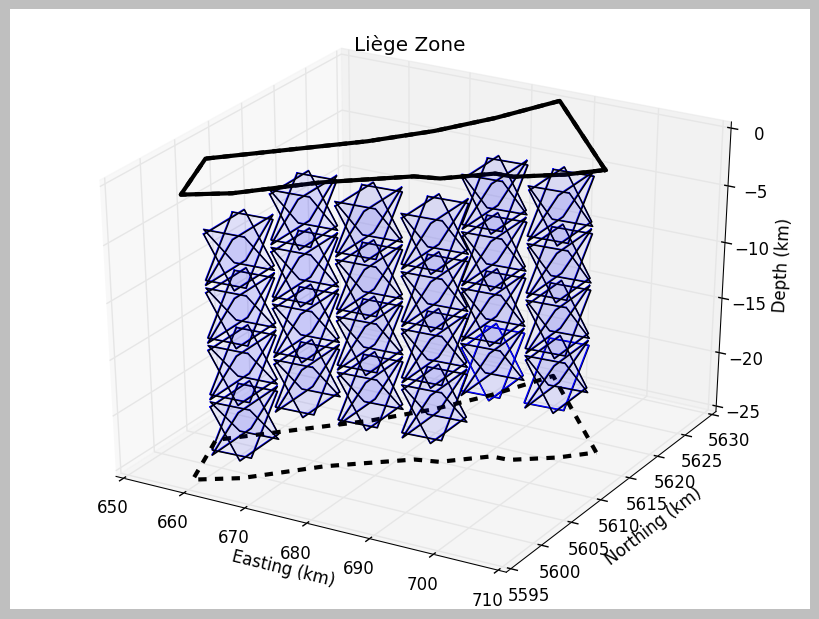

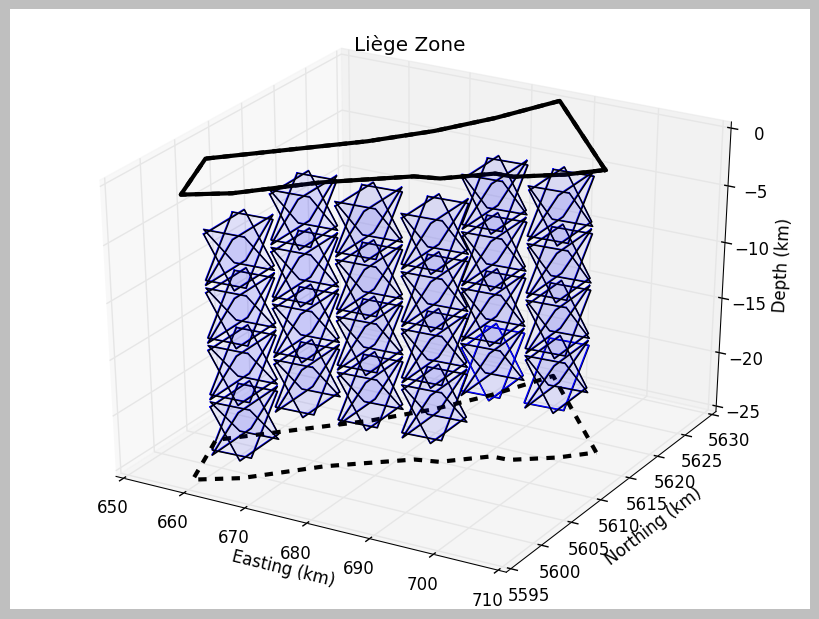

In [23]:
zone = source_model["LIE"]
mag = 5.55
rake = 0
ruptures = zone.get_ruptures_poisson(mag=mag, rake=rake)
print(len(ruptures))
print(zone)
zone.plot_rupture_bounds_3d(ruptures, fill=True)

Fault source: all possible ruptures of a given magnitude

<class 'hazard.rshalib.source.simple_fault.SimpleFaultSource'>
False


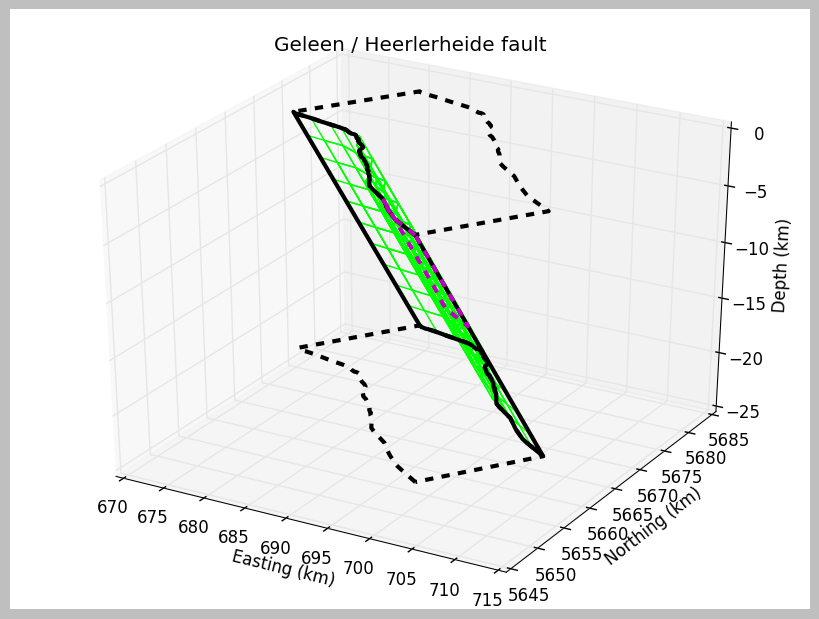

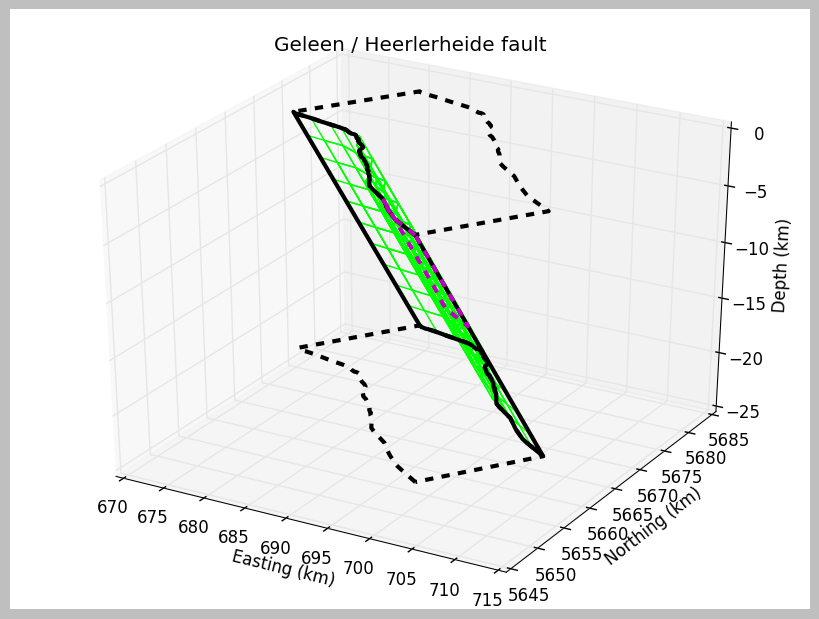

In [24]:
fault = source_model["GeHeF"]
mag = 6.05
ruptures = fault.get_ruptures_poisson(mag=mag)
fault.plot_rupture_bounds_3d(ruptures, fill=False)

## 5. Construct ground-motion model

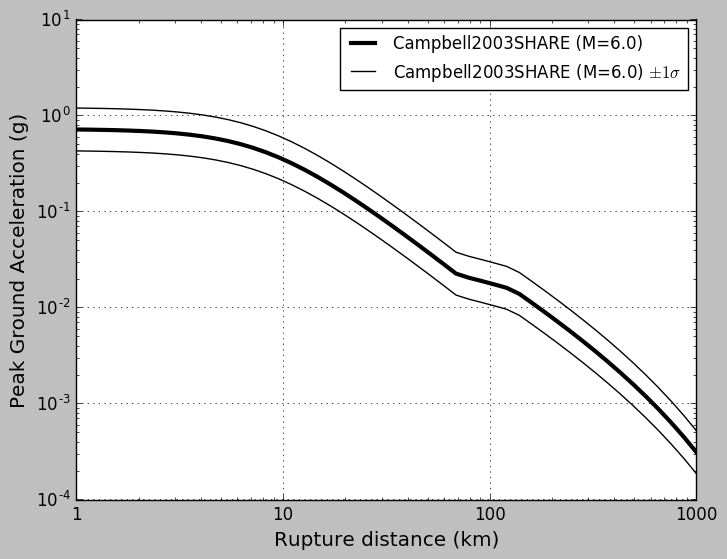

In [25]:
ground_motion_model = rshalib.gsim.GroundMotionModel('Mixed',
                                    {'Active Shallow Crust': 'AkkarBommer2010',
                                       'Stable Shallow Crust': 'Campbell2003SHARE'})
gmpe_name = ground_motion_model["Stable Shallow Crust"]
gmpe = getattr(rshalib.gsim, gmpe_name)()
gmpe.plot_distance([6], 1, epsilon=1)

E:\Home\_kris\Python\seismo\hazard\rshalib\gsim\gmpe\oqhazlib_gmpe.py:242: RuntimeWarning: invalid value encountered in sqrt
  d = np.sqrt(np.asarray(d)**2 - depth**2)


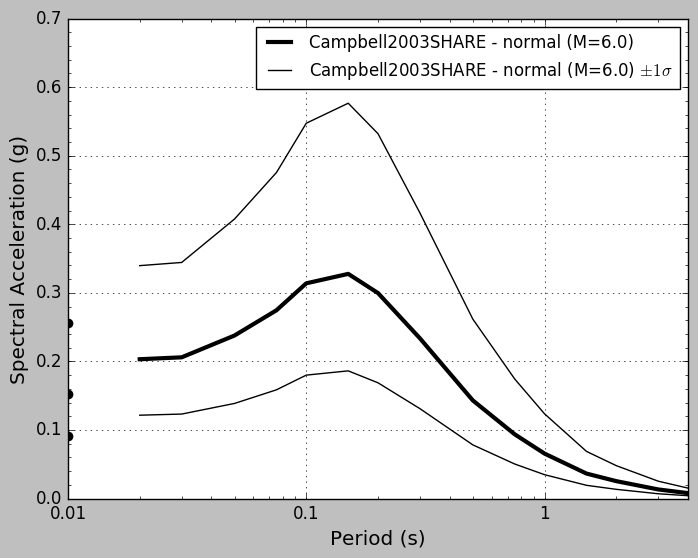

In [26]:
gmpe.plot_spectrum([6], 1, 20, epsilon=1, pgm_period=1./100)

## 6. Construct PSHA model

We keep only the source "Anglo-Brabant Massif" to reduce computing time.

In [27]:
source_model.sources = [source_model["ABM"]]
source_model.validate()

In [28]:
def create_oq_params():
    """"
    Generate additional OpenQuake params not automatically handled by pshamodel
    """
    OQparams = {}
    OQparams['export_dir'] = 'output'
    return OQparams


def create_psha_model(engine="oqhazlib"):
    """
    :param engine:
        String, name of hazard engine: "oqhazlib", "openquake" or "crisis"
        (default: "oqhazlib")
    """
    root_folder = os.path.join(psha_model_folder, engine)
    if not os.path.exists(root_folder):
        os.mkdir(root_folder)

    return rshalib.shamodel.PSHAModel(psha_model_name, source_model, ground_motion_model,
                    root_folder=root_folder,
                    site_model=site_model, imt_periods=imt_periods,
                    min_intensities=Imin, max_intensities=Imax, num_intensities=num_intensities,
                    return_periods=return_periods, time_span=investigation_time,
                    truncation_level=gmpe_truncation_level, integration_distance=integration_distance)

## 7. Run PSHA model

### 7.1 rshalib

Computation takes about 5 minutes, so we can take a cup of coffee.

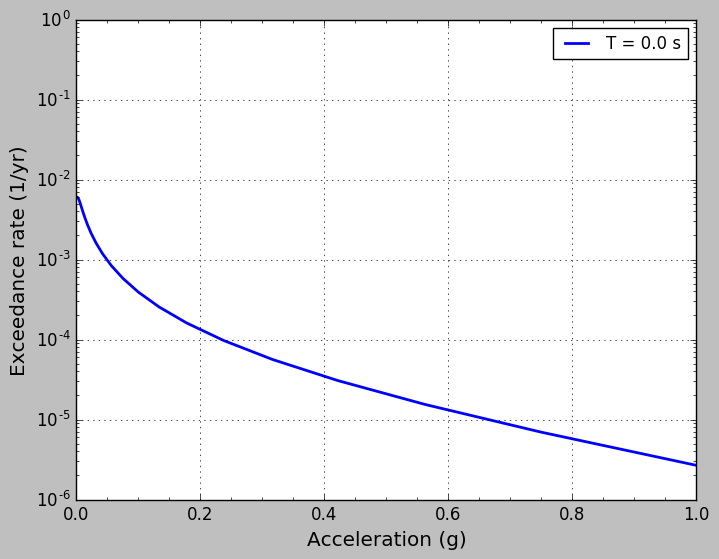

In [30]:
psha_model = create_psha_model("oqhazlib")
shcf_dict = psha_model.calc_shcf()
shcf_dict['PGA'].plot()

### 7.2 OpenQuake

In [ ]:
psha_model = create_psha_model("openquake")
OQparams = create_oq_params()
psha_model.write_openquake(user_params=OQparams)

In [ ]:
xml_folder = os.path.join(psha_model_folder, "openquake", "output")
#rename_output_files(xml_folder)
gmpe_name = ground_motion_model["Active Shallow Crust"]
nrml_filespec = os.path.join(xml_folder, gmpe_name, "PGA", "hazard-curves-32.xml")
hcf = rshalib.openquake.parse_hazard_curves(nrml_filespec)
hcf.plot()

### 7.3 CRISIS

In [ ]:
psha_model = create_psha_model("crisis")
gra_filespec = psha_model.write_crisis(overwrite=True)

In [ ]:
shcf = rshalib.crisis.readCRISIS_GRA(os.path.splitext(gra_filespec)[0])
shcf.plot()